In [2]:
#memanggil packages yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from scipy.stats import boxcox,  boxcox_llf

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
file_path = "pelabuhan balikpapan.xlsx"
data = pd.read_excel(file_path, engine="openpyxl")
print(data)

         Bulan  Balikpapan
0   2006-01-01       19838
1   2006-02-01       15415
2   2006-03-01       16200
3   2006-04-01       14819
4   2006-05-01       14143
..         ...         ...
223 2024-08-01       32056
224 2024-09-01       26189
225 2024-10-01       24914
226 2024-11-01       25714
227 2024-12-01       21276

[228 rows x 2 columns]


Data dalam Format Waktu

In [4]:
print(data.dtypes)

Bulan         datetime64[ns]
Balikpapan             int64
dtype: object


In [6]:
data['Bulan'] = pd.to_datetime(data['Bulan'], format='%Y-%m')
y = data.set_index('Bulan')
y.index

DatetimeIndex(['2006-01-01', '2006-02-01', '2006-03-01', '2006-04-01',
               '2006-05-01', '2006-06-01', '2006-07-01', '2006-08-01',
               '2006-09-01', '2006-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='Bulan', length=228, freq=None)

In [7]:
y.isnull().sum()

Balikpapan    0
dtype: int64

Plot Data Musiman

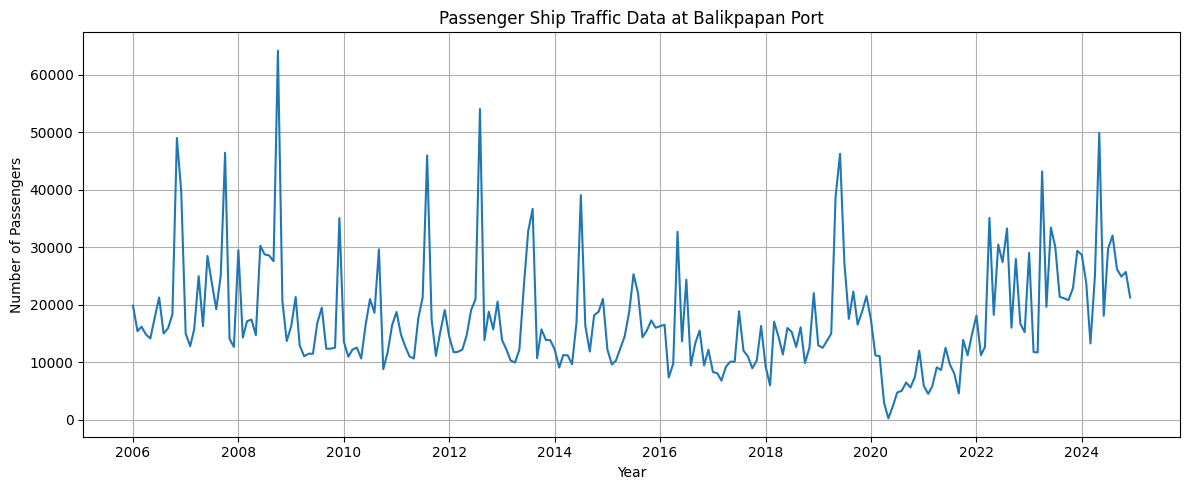

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Ubah kolom waktu ke datetime
data['Bulan'] = pd.to_datetime(data['Bulan'])  # Ganti 'Tanggal' sesuai nama kolom waktumu
data.set_index('Bulan', inplace=True)

# Atur frekuensi kalau datanya bulanan
data = data.asfreq('MS')  # MS = Month Start

# Plot ulang
plt.figure(figsize=(12, 5))
plt.plot(data.index, data['Balikpapan'], color='tab:blue')
plt.title('Passenger Ship Traffic Data at Balikpapan Port')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

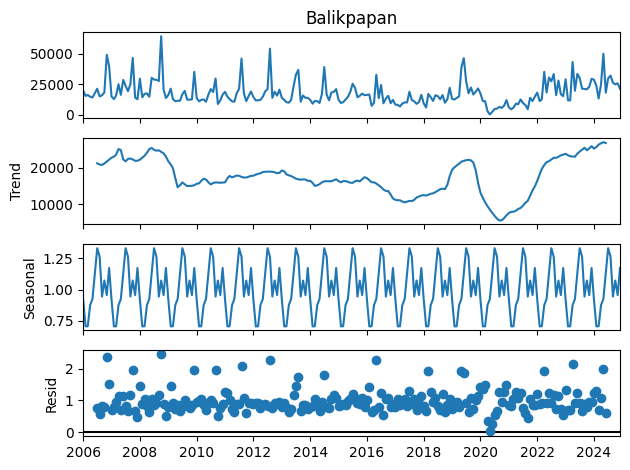

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Dekomposisi data
decomposition = seasonal_decompose(data['Balikpapan'], model='mu', period=12)  # period=12 untuk data bulanan

# Plot hasil dekomposisi
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.tight_layout()
plt.show()

Split Data

In [10]:
# Pembagian data latih dan uji
train = data[data.index.year <= 2023]  # Data latih sampai akhir 2023
test = data[data.index.year > 2023]    # Data uji dari awal 2023

# Cek hasil pembagian
print(f"Training: {train.index[0].date()} sampai {train.index[-1].date()} ({len(train)} bulan)")
print(f"Testing: {test.index[0].date()} sampai {test.index[-1].date()} ({len(test)} bulan)")

Training: 2006-01-01 sampai 2023-12-01 (216 bulan)
Testing: 2024-01-01 sampai 2024-12-01 (12 bulan)


Plot data Testing & Training

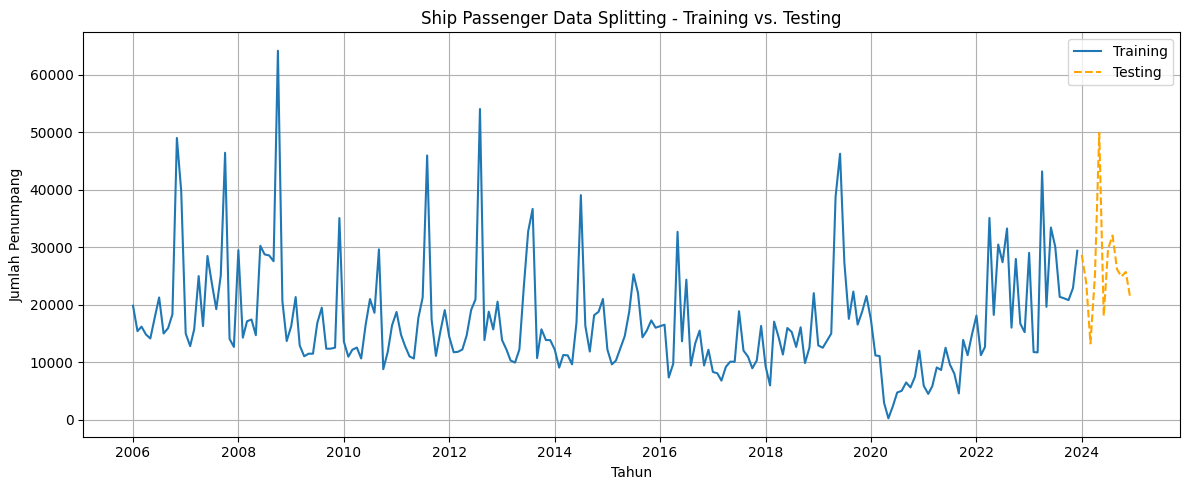

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['Balikpapan'], label='Training')
plt.plot(test.index, test['Balikpapan'], label='Testing', linestyle='--', color='orange')
plt.title('Ship Passenger Data Splitting - Training vs. Testing')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Penumpang')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plot ACF PACF

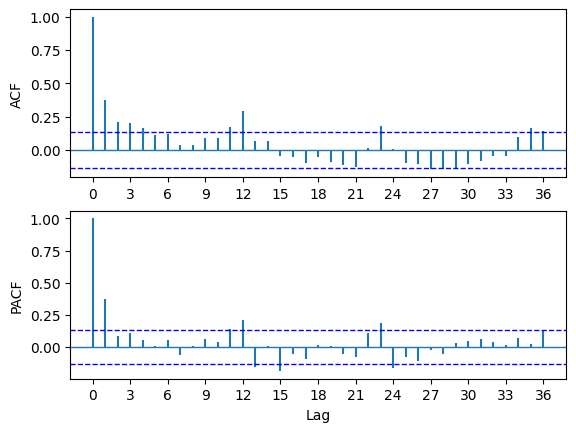

In [12]:
acf_pacf_fig(train['Balikpapan'], both=True, lag=36)

ADF Test

In [13]:
from statsmodels.tsa.stattools import adfuller

# Jalankan uji ADF pada data balikpapan
adf_result = adfuller(train['Balikpapan'].dropna(), autolag='AIC')

# Ambil p-value dari hasil uji ADF
p_value = adf_result[1]

# Cetak hasil
print(f"P-value ADF Test: {p_value}")

P-value ADF Test: 0.06398401956551965


Nilai Lambda

In [20]:
from scipy.stats import boxcox

# Pastikan semua nilai positif sebelum Box-Cox
if (train['Balikpapan'] <= 0).any():
    train['Balikpapan'] += abs(train['Balikpapan'].min()) + 1  # Geser ke positif

# Terapkan transformasi Box-Cox
data_boxcox, lambda_fit, ci = boxcox(train['Balikpapan'], alpha=0.05)

# Cetak hasil
print(f"Nilai Lambda: {lambda_fit}")
print(f"Interval Kepercayaan Lambda: {ci}")

Nilai Lambda: 0.31905338236027675
Interval Kepercayaan Lambda: (0.19375429329992447, 0.45739090134576765)


Differencing

In [21]:
# Differencing pertama
diff_1 = train['Balikpapan'].diff().dropna()

Uji Box Cox

In [22]:
from scipy.stats import boxcox

# Pastikan semua nilai positif sebelum Box-Cox
if (diff_1 <= 0).any():
    diff_1 += abs(diff_1.min()) + 1  # Geser ke positif

# Terapkan transformasi Box-Cox
data_boxcox, lambda_fit, ci = boxcox(diff_1, alpha=0.05)

# Cetak hasil
print(f"Nilai Lambda: {lambda_fit}")
print(f"Interval Kepercayaan Lambda: {ci}")

Nilai Lambda: 1.148208106688901
Interval Kepercayaan Lambda: (0.9360584598788299, 1.386569937852693)


In [23]:
from statsmodels.tsa.stattools import adfuller
adfuller(diff_1, autolag='AIC')[1]

np.float64(0.00011347765996421213)

Plot ACF PACF Setelah Differencing

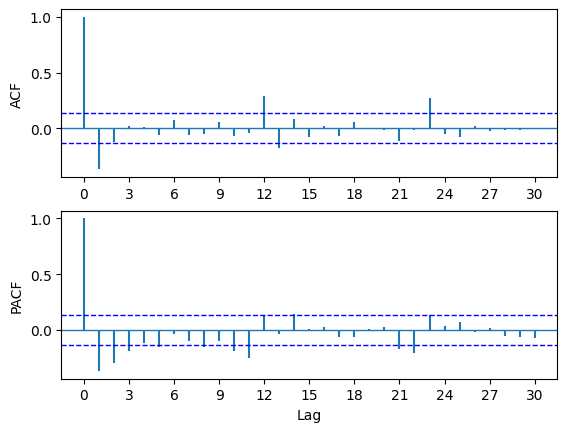

In [24]:
acf_pacf_fig(diff_1, both=True, lag=30); plt.show()

Differencing Musiman

In [25]:
diff_seasonal = diff_1.diff(12).dropna()

In [26]:
from statsmodels.tsa.stattools import adfuller
adfuller(diff_seasonal, autolag='AIC')[1]

np.float64(1.9202802330516213e-08)

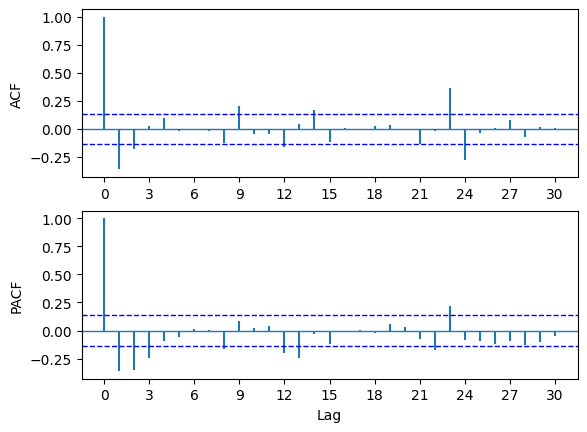

In [27]:
acf_pacf_fig(diff_seasonal, both=True, lag=30)
plt.show()

Model SARIMA

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [29]:
model_1 = SARIMAX(train['Balikpapan'],
                  order=(1, 1, 1),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
result_1 = model_1.fit(disp=False)
print(result_1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1980.766
Date:                            Wed, 25 Jun 2025   AIC                           3971.532
Time:                                    00:52:21   BIC                           3987.741
Sample:                                01-01-2006   HQIC                          3978.099
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1258      0.146      0.860      0.390      -0.161       0.413
ma.L1         -0.7593      0.102   

In [30]:
model_2 = SARIMAX(train['Balikpapan'],
                  order=(1, 1, 2),
                  seasonal_order=(1, 1, 2, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_2 = model_2.fit()
print(result_2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1837.715
Date:                            Wed, 25 Jun 2025   AIC                           3689.429
Time:                                    00:52:37   BIC                           3711.623
Sample:                                01-01-2006   HQIC                          3698.431
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4464      1.268     -0.352      0.725      -2.931       2.039
ma.L1         -0.1886      1.245   

In [31]:
model_3 = SARIMAX(train['Balikpapan'],
                  order=(2, 1, 1),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_3 = model_3.fit()
print(result_3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1980.351
Date:                            Wed, 25 Jun 2025   AIC                           3972.703
Time:                                    00:52:50   BIC                           3992.153
Sample:                                01-01-2006   HQIC                          3980.583
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0843      0.189      0.446      0.655      -0.286       0.454
ar.L2         -0.0367      0.161   

In [32]:
model_31 = SARIMAX(train['Balikpapan'],
                  order=(3, 1, 1),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_31 = model_31.fit()
print(result_31.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(3, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1968.484
Date:                            Wed, 25 Jun 2025   AIC                           3950.967
Time:                                    00:53:14   BIC                           3973.622
Sample:                                01-01-2006   HQIC                          3960.146
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3060      0.121      2.532      0.011       0.069       0.543
ar.L2          0.0968      0.112   

In [33]:
model_12 = SARIMAX(train['Balikpapan'],
                  order=(1, 1, 2),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_12 = model_12.fit()
print(result_12.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Balikpapan   No. Observations:                  216
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1970.526
Date:                              Wed, 25 Jun 2025   AIC                           3953.053
Time:                                      00:53:25   BIC                           3972.472
Sample:                                  01-01-2006   HQIC                          3960.921
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2678      1.053     -0.254      0.799      -2.331       1.795
ma.L1         -0.36

In [34]:
model_22 = SARIMAX(train['Balikpapan'],
                  order=(2, 1, 2),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_22 = model_22.fit()
print(result_22.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Balikpapan   No. Observations:                  216
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1968.646
Date:                              Wed, 25 Jun 2025   AIC                           3951.292
Time:                                      00:53:47   BIC                           3973.948
Sample:                                  01-01-2006   HQIC                          3960.471
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7591      0.301      2.521      0.012       0.169       1.349
ar.L2         -0.00

In [35]:
model_32 = SARIMAX(train['Balikpapan'],
                  order=(3, 1, 2),
                  seasonal_order=(1, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_32 = model_32.fit()
print(result_32.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Balikpapan   No. Observations:                  216
Model:             SARIMAX(3, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -1968.083
Date:                              Wed, 25 Jun 2025   AIC                           3952.166
Time:                                      00:53:59   BIC                           3978.058
Sample:                                  01-01-2006   HQIC                          3962.656
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5988      0.347      1.728      0.084      -0.080       1.278
ar.L2         -0.01

In [36]:
model_4 = SARIMAX(train['Balikpapan'],
                  order=(1, 1, 1),
                  seasonal_order=(2, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_4 = model_4.fit()
print(result_4.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1860.300
Date:                            Wed, 25 Jun 2025   AIC                           3732.599
Time:                                    00:54:40   BIC                           3751.690
Sample:                                01-01-2006   HQIC                          3740.341
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1340      0.182      0.737      0.461      -0.223       0.491
ma.L1         -0.7671      0.126   

In [37]:
model_5 = SARIMAX(train['Balikpapan'],
                   order=(2, 1, 2),
                  seasonal_order=(1, 1, 2, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_5 = model_5.fit()
print(result_5.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1837.091
Date:                            Wed, 25 Jun 2025   AIC                           3690.183
Time:                                    00:54:53   BIC                           3715.547
Sample:                                01-01-2006   HQIC                          3700.470
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5358      2.123     -0.252      0.801      -4.697       3.625
ar.L2          0.0372      0.409   

In [38]:
model_6 = SARIMAX(train['Balikpapan'],
                   order=(3, 1, 2),
                  seasonal_order=(1, 1, 2, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_6 = model_6.fit()
print(result_6.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -1836.945
Date:                            Wed, 25 Jun 2025   AIC                           3691.891
Time:                                    00:55:10   BIC                           3720.425
Sample:                                01-01-2006   HQIC                          3703.464
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7862      0.510     -1.541      0.123      -1.786       0.214
ar.L2          0.0164      0.405   

In [39]:
model_7 = SARIMAX(train['Balikpapan'],
                   order=(2, 1, 3),
                  seasonal_order=(1, 1, 2, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_7 = model_7.fit()
print(result_7.summary())

                                        SARIMAX Results                                        
Dep. Variable:                              Balikpapan   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1, 2], 12)   Log Likelihood               -1819.531
Date:                                 Wed, 25 Jun 2025   AIC                           3657.061
Time:                                         00:55:26   BIC                           3685.544
Sample:                                     01-01-2006   HQIC                          3668.615
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2366      1.246      0.190      0.849      -2.206       2

In [40]:
model_8 = SARIMAX(train['Balikpapan'],
                   order=(2, 1, 2),
                  seasonal_order=(2, 1, 2, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_8 = model_8.fit()
print(result_8.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1837.130
Date:                            Wed, 25 Jun 2025   AIC                           3692.260
Time:                                    00:55:43   BIC                           3720.795
Sample:                                01-01-2006   HQIC                          3703.834
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2479      2.536      0.098      0.922      -4.723       5.218
ar.L2         -0.0468      0.403   

In [41]:
model_9 = SARIMAX(train['Balikpapan'],
                   order=(2, 1, 2),
                  seasonal_order=(1, 1, 3, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)

result_9 = model_9.fit()
print(result_9.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                 Balikpapan   No. Observations:                  216
Model:             SARIMAX(2, 1, 2)x(1, 1, [1, 2, 3], 12)   Log Likelihood               -1708.560
Date:                                    Wed, 25 Jun 2025   AIC                           3435.120
Time:                                            00:56:11   BIC                           3463.019
Sample:                                        01-01-2006   HQIC                          3446.446
                                             - 12-01-2023                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6022      0.834      0.722      0

In [42]:
model_10 = SARIMAX(train['Balikpapan'],
                  order=(3, 1, 1),
                  seasonal_order=(2, 1, 1, 12),
                  enforce_stationarity=False,
                  enforce_invertibility=False)
result_10 = model_10.fit(disp=False)
print(result_10.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         Balikpapan   No. Observations:                  216
Model:             SARIMAX(3, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -1837.646
Date:                            Wed, 25 Jun 2025   AIC                           3691.293
Time:                                    00:56:41   BIC                           3716.656
Sample:                                01-01-2006   HQIC                          3701.580
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2937      0.153      1.919      0.055      -0.006       0.594
ar.L2          0.0463      0.150   

Diagnostik Model

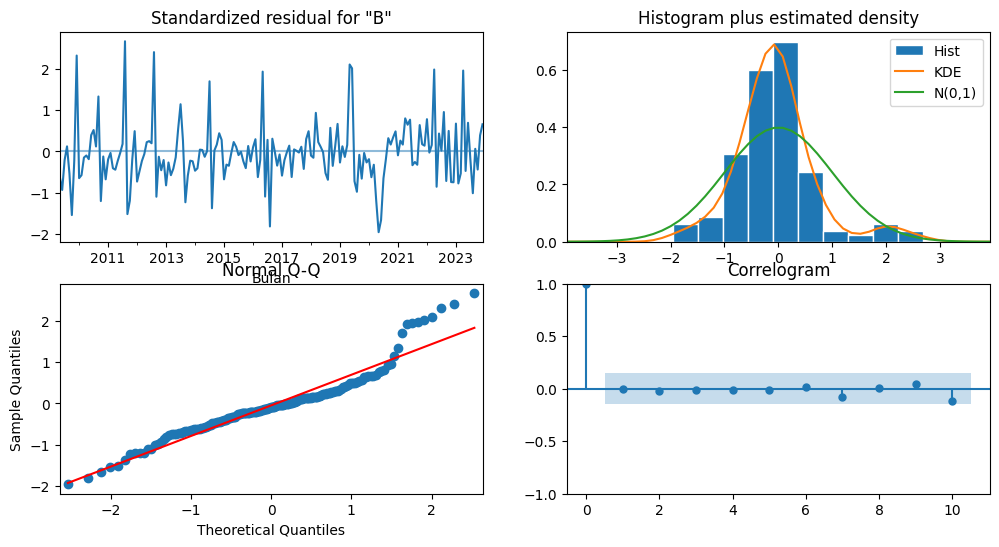

In [43]:
result_5.plot_diagnostics(figsize=(12, 6))
plt.show()

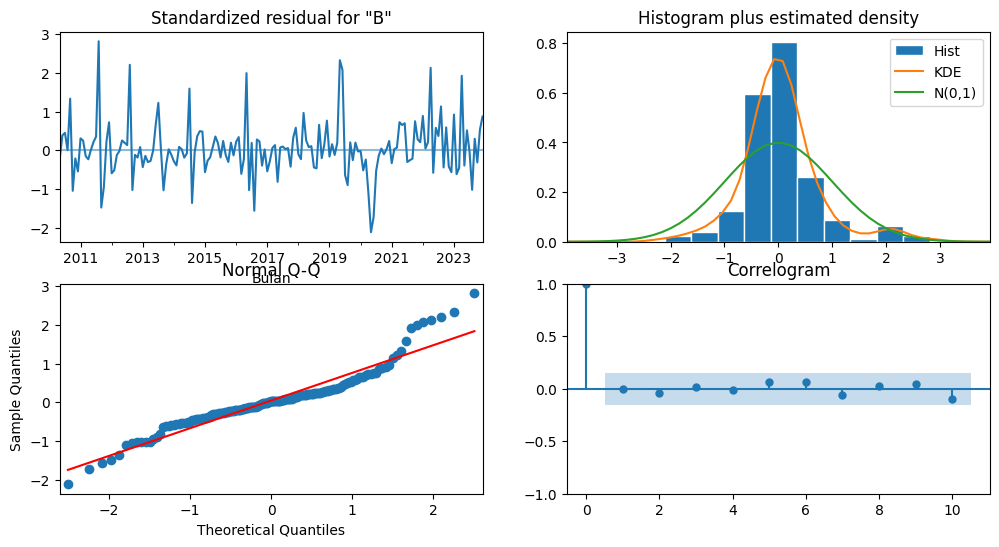

In [44]:
result_9.plot_diagnostics(figsize=(12, 6))
plt.show()

In [45]:
residuals5 = result_5.resid
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_result = acorr_ljungbox(residuals5, lags=[10], return_df=True)
print(ljung_result)

     lb_stat  lb_pvalue
10  5.718391   0.838342


In [46]:
residuals9 = result_9.resid
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_result = acorr_ljungbox(residuals9, lags=[10], return_df=True)
print(ljung_result)

      lb_stat  lb_pvalue
10  12.323432   0.263993


In [47]:
from scipy.stats import jarque_bera

# Lakukan uji Jarque-Bera
jb_stat, jb_pvalue = jarque_bera(residuals5)

# Tampilkan hasil
print(f"Statistik JB  : {jb_stat:.4f}")
print(f"P-Value        : {jb_pvalue:.4f}")

# Interpretasi hasil
if jb_pvalue < 0.05:
    print("Residual tidak berdistribusi normal (Tolak H0)")
else:
    print("Residual kemungkinan normal (Gagal Tolak H0)")

Statistik JB  : 76.4576
P-Value        : 0.0000
Residual tidak berdistribusi normal (Tolak H0)


In [48]:
from sklearn.metrics import mean_absolute_percentage_error

# Simpan model dalam list
models = [result_1, result_2, result_3, result_4, result_5, result_6, result_7, result_8, result_9, result_10]

# Inisialisasi list hasil
mape_list = []

# Loop hitung MAPE
for i, model in enumerate(models, start=1):
    forecast = model.forecast(steps=len(test))
    mape = mean_absolute_percentage_error(test['Balikpapan'], forecast)
    mape_list.append((f"result_{i}", mape))

# Tampilkan hasil sebagai DataFrame
mape_df = pd.DataFrame(mape_list, columns=["Model", "MAPE"])
mape_df["MAPE (%)"] = mape_df["MAPE"] * 100
print(mape_df[["Model", "MAPE (%)"]])

       Model   MAPE (%)
0   result_1  26.401961
1   result_2  25.086487
2   result_3  26.557401
3   result_4  23.757090
4   result_5  25.030403
5   result_6  25.161788
6   result_7  25.294813
7   result_8  25.799514
8   result_9  24.848396
9  result_10  25.281172


In [49]:
# Model terbaik yang sudah kamu pilih
bestmodel = result_5

# Prediksi data testing
forecast_sarima = bestmodel.forecast(steps=len(test))

# Buat DataFrame perbandingan
comparison_df = pd.DataFrame({
    'Aktual': test['Balikpapan'],
    'Prediksi': forecast_sarima
})

# (Opsional) Tampilkan hasil
comparison_df.head()

,Aktual,Prediksi
2024-01-01,28670,27045.397217
2024-02-01,23760,19350.040276
2024-03-01,13276,19547.740740
2024-04-01,25040,30354.602740
2024-05-01,49918,26071.811144


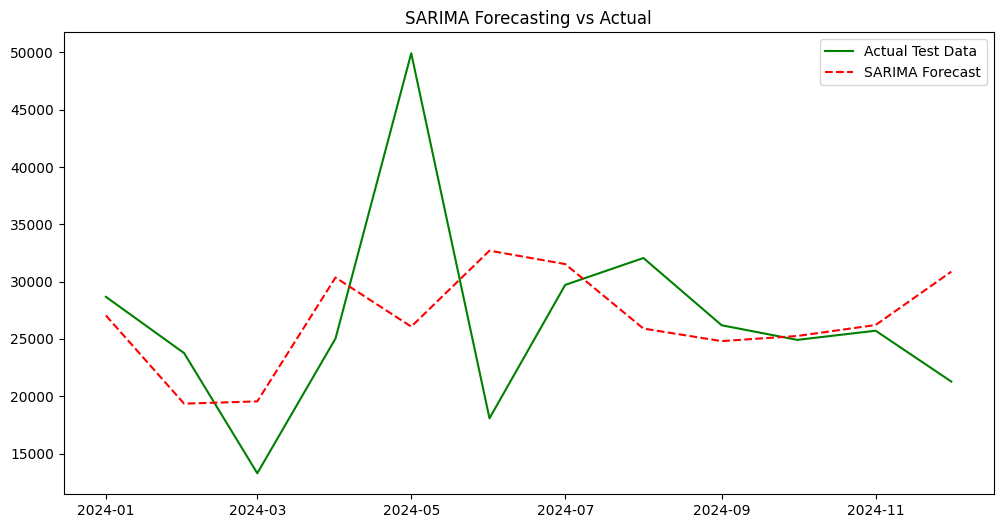

In [50]:
#Plot hasil prediksi vs aktual
plt.figure(figsize=(12,6))
#plt.plot(train.index, train, label="Train Data")
plt.plot(test.index, test, label="Actual Test Data", color='green')
plt.plot(test.index, forecast_sarima, label="SARIMA Forecast", color='red', linestyle='dashed')
plt.legend()
plt.title("SARIMA Forecasting vs Actual")
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

maes = mean_absolute_error(test, forecast_sarima)
rmses = np.sqrt(mean_squared_error(test, forecast_sarima))

print(f"MAE: {maes:.2f}")
print(f"RMSE: {rmses:.2f}")

MAE: 6322.95
RMSE: 9163.62


Prophet

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
from scipy.stats import shapiro
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

Load & Preprocess Data

In [80]:
file_path = "pelabuhan balikpapan.xlsx"
data = pd.read_excel(file_path, engine="openpyxl")
data['Bulan'] = pd.to_datetime(data['Bulan'], format='%Y-%m')
prophet_data = data.rename(columns={'Bulan': 'ds', 'Balikpapan': 'y'})[['ds', 'y']]
train_prophet = prophet_data[prophet_data['ds'].dt.year <= 2023]
test_prophet = prophet_data[prophet_data['ds'].dt.year > 2023]

Definisi Hari Libur

In [81]:
liburan_id = pd.DataFrame({
    'holiday': 'libur_nasional',
    'ds': pd.to_datetime([
        '2022-01-01', '2022-05-02', '2022-12-25',
        '2023-01-01', '2023-04-22', '2023-12-25',
        '2024-01-01', '2024-04-10', '2024-12-25',
        '2025-01-01', '2025-04-17', '2025-12-25'
    ]),
    'lower_window': 0,
    'upper_window': 1
})

Grid Search Parameter

In [82]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
rmses = []

print("🔍 Sedang melakukan grid search...")
for i, params in enumerate(all_params):
    print(f"Evaluasi kombinasi ke-{i+1}/{len(all_params)}: {params}")
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        holidays=liburan_id
    )
    model.add_country_holidays(country_name='ID')
    model.fit(train_prophet)

    df_cv = cross_validation(model, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])


🔍 Sedang melakukan grid search...
Evaluasi kombinasi ke-1/24: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


01:31:21 - cmdstanpy - INFO - Chain [1] start processing
01:31:21 - cmdstanpy - INFO - Chain [1] done processing
01:31:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
01:31:22 - cmdstanpy - INFO - Chain [1] start processing
01:31:27 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-2/24: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


01:31:43 - cmdstanpy - INFO - Chain [1] start processing
01:31:43 - cmdstanpy - INFO - Chain [1] done processing
01:31:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
01:31:43 - cmdstanpy - INFO - Chain [1] start processing
01:31:44 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-3/24: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


01:32:13 - cmdstanpy - INFO - Chain [1] start processing
01:32:13 - cmdstanpy - INFO - Chain [1] done processing
01:32:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
01:32:14 - cmdstanpy - INFO - Chain [1] start processing
01:32:14 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-4/24: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}


01:32:36 - cmdstanpy - INFO - Chain [1] start processing
01:32:36 - cmdstanpy - INFO - Chain [1] done processing
01:32:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
01:32:36 - cmdstanpy - INFO - Chain [1] start processing
01:32:37 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-5/24: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


01:33:01 - cmdstanpy - INFO - Chain [1] start processing
01:33:01 - cmdstanpy - INFO - Chain [1] done processing
01:33:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
01:33:01 - cmdstanpy - INFO - Chain [1] start processing
01:33:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-6/24: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


01:33:25 - cmdstanpy - INFO - Chain [1] start processing
01:33:26 - cmdstanpy - INFO - Chain [1] done processing
01:33:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
01:33:26 - cmdstanpy - INFO - Chain [1] start processing
01:33:26 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-7/24: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


01:33:48 - cmdstanpy - INFO - Chain [1] start processing
01:33:48 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-8/24: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


01:34:17 - cmdstanpy - INFO - Chain [1] start processing
01:34:17 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-9/24: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


01:34:28 - cmdstanpy - INFO - Chain [1] start processing
01:34:28 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-10/24: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}


01:34:37 - cmdstanpy - INFO - Chain [1] start processing
01:34:37 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-11/24: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


01:34:47 - cmdstanpy - INFO - Chain [1] start processing
01:34:47 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-12/24: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


01:34:58 - cmdstanpy - INFO - Chain [1] start processing
01:34:58 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-13/24: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


01:35:10 - cmdstanpy - INFO - Chain [1] start processing
01:35:10 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-14/24: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


01:35:38 - cmdstanpy - INFO - Chain [1] start processing
01:35:38 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-15/24: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


01:36:01 - cmdstanpy - INFO - Chain [1] start processing
01:36:01 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-16/24: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}


01:36:30 - cmdstanpy - INFO - Chain [1] start processing
01:36:30 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-17/24: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


01:37:05 - cmdstanpy - INFO - Chain [1] start processing
01:37:05 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-18/24: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


01:37:33 - cmdstanpy - INFO - Chain [1] start processing
01:37:33 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-19/24: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}


01:38:08 - cmdstanpy - INFO - Chain [1] start processing
01:38:08 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-20/24: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


01:38:37 - cmdstanpy - INFO - Chain [1] start processing
01:38:37 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-21/24: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'additive'}


01:39:07 - cmdstanpy - INFO - Chain [1] start processing
01:39:08 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-22/24: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}


01:39:41 - cmdstanpy - INFO - Chain [1] start processing
01:39:41 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-23/24: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}


01:40:16 - cmdstanpy - INFO - Chain [1] start processing
01:40:16 - cmdstanpy - INFO - Chain [1] done processing


Evaluasi kombinasi ke-24/24: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


01:40:49 - cmdstanpy - INFO - Chain [1] start processing
01:40:49 - cmdstanpy - INFO - Chain [1] done processing


Parameter terbaik

In [83]:
best_params = all_params[np.argmin(rmses)]
print("✅ Best Parameters:", best_params)

✅ Best Parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


Final Model Prophet

In [84]:
model_prophet = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    holidays=liburan_id
)
model_prophet.add_country_holidays(country_name='ID')
model_prophet.fit(train_prophet)

01:42:52 - cmdstanpy - INFO - Chain [1] start processing
01:42:52 - cmdstanpy - INFO - Chain [1] done processing
01:42:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
01:42:52 - cmdstanpy - INFO - Chain [1] start processing
01:42:53 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
from prophet import Prophet

model_prophet = Prophet(holidays=liburan_id)
model_prophet.add_country_holidays(country_name='ID')  # 'ID' = Indonesia
model_prophet.fit(train_prophet)

01:05:09 - cmdstanpy - INFO - Chain [1] start processing
01:05:09 - cmdstanpy - INFO - Chain [1] done processing


Forecast

In [85]:
future = model_prophet.make_future_dataframe(periods=len(test_prophet), freq='MS')
forecast = model_prophet.predict(future)

Evaluasi Akurasi

In [86]:
forecast_test = forecast[['ds', 'yhat']].set_index('ds').join(test_prophet.set_index('ds')).dropna()
mae = mean_absolute_error(forecast_test['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(forecast_test['y'], forecast_test['yhat']))
mape = np.mean(np.abs((forecast_test['y'] - forecast_test['yhat']) / forecast_test['y'])) * 100

print(f"\n📊 Evaluasi:")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


📊 Evaluasi:
MAE : 11333.22
RMSE: 14081.98
MAPE: 38.88%


Plot Forecast

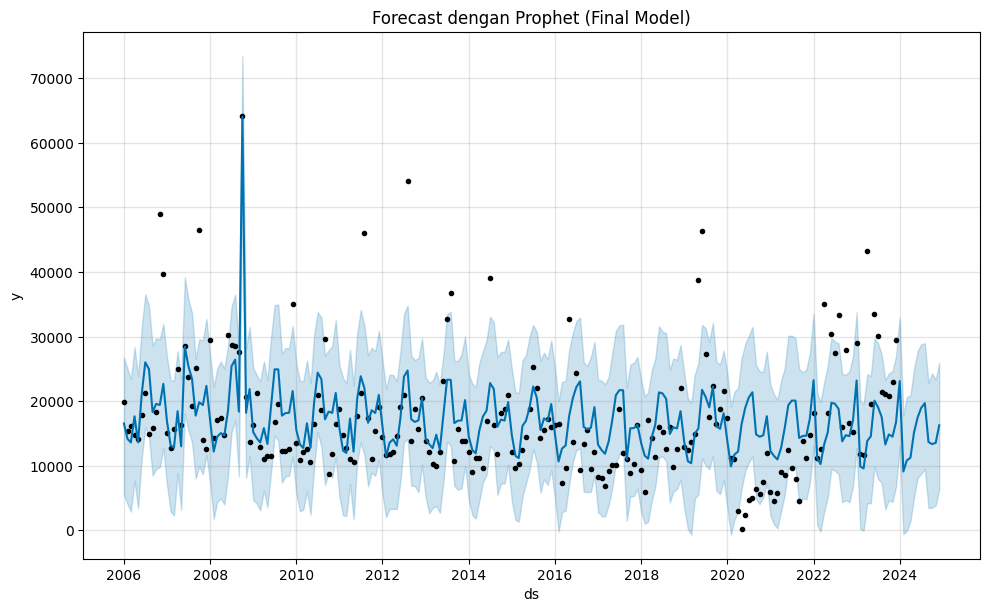

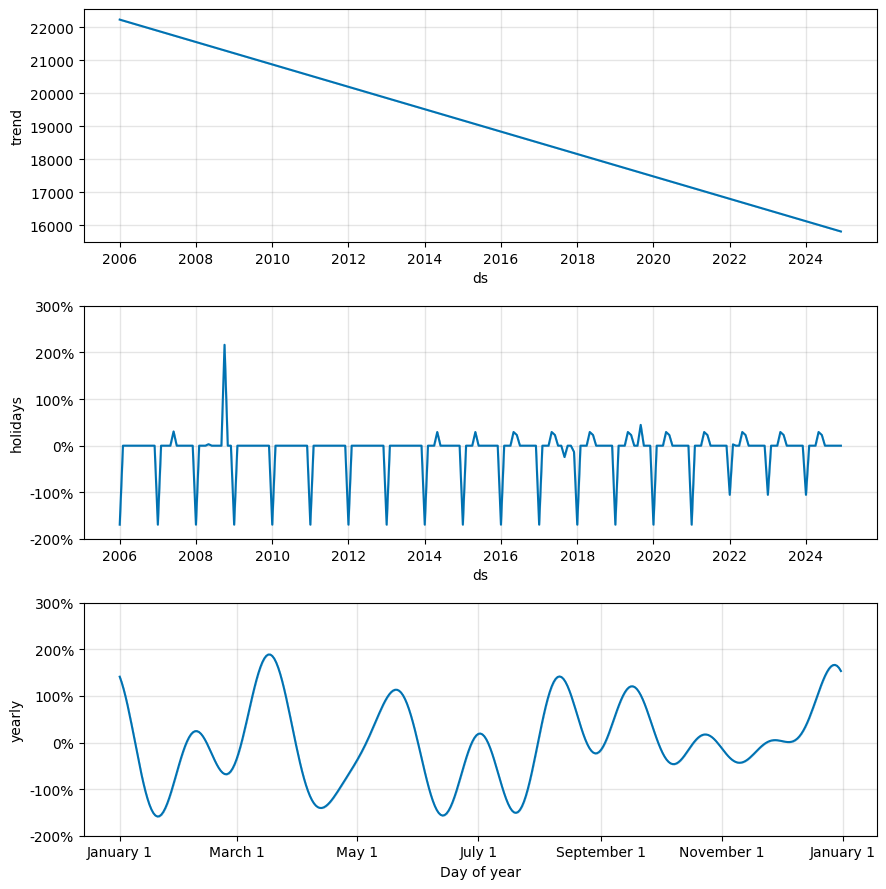

In [87]:
model_prophet.plot(forecast)
plt.title("Forecast dengan Prophet (Final Model)")
plt.show()

model_prophet.plot_components(forecast)
plt.show()

Visualisasi Hasil Test

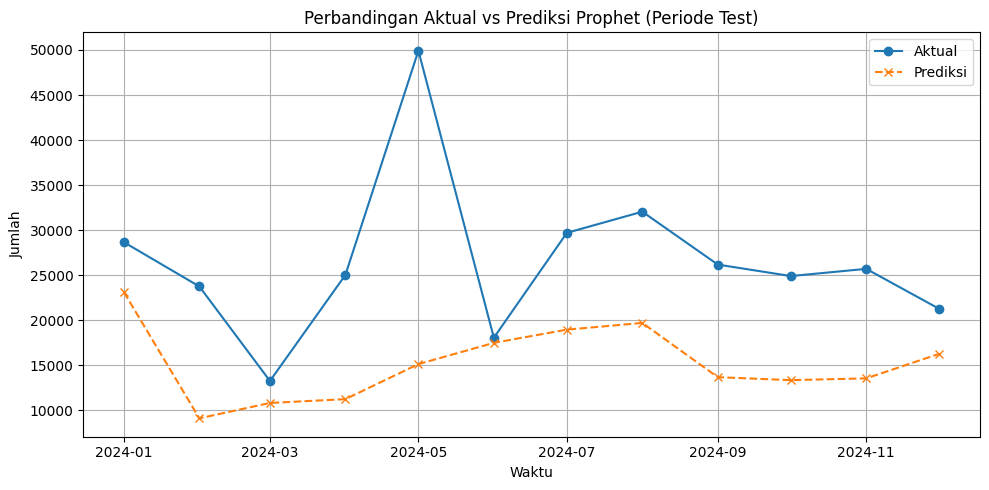

In [88]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_test.index, forecast_test['y'], label='Aktual', marker='o')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Prediksi', linestyle='--', marker='x')
plt.title('Perbandingan Aktual vs Prediksi Prophet (Periode Test)')
plt.xlabel('Waktu')
plt.ylabel('Jumlah')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Analisis Residual

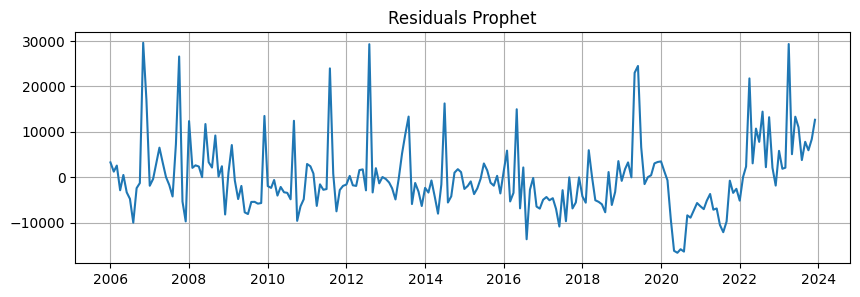

In [89]:
forecast_historic = forecast[forecast['ds'].isin(train_prophet['ds'])]
merged = pd.merge(train_prophet, forecast_historic[['ds', 'yhat']], on='ds')
merged['residual'] = merged['y'] - merged['yhat']
residuals = merged['residual']

plt.figure(figsize=(10, 3))
plt.plot(merged['ds'], residuals)
plt.title('Residuals Prophet')
plt.grid(True)
plt.show()

ACF

<Figure size 800x400 with 0 Axes>

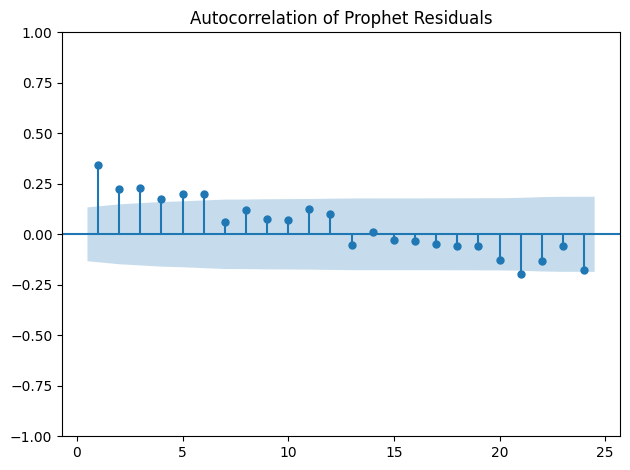

In [90]:
plt.figure(figsize=(8, 4))
plot_acf(residuals, lags=24, zero=False)
plt.title('Autocorrelation of Prophet Residuals')
plt.tight_layout()
plt.show()

QQ Plot

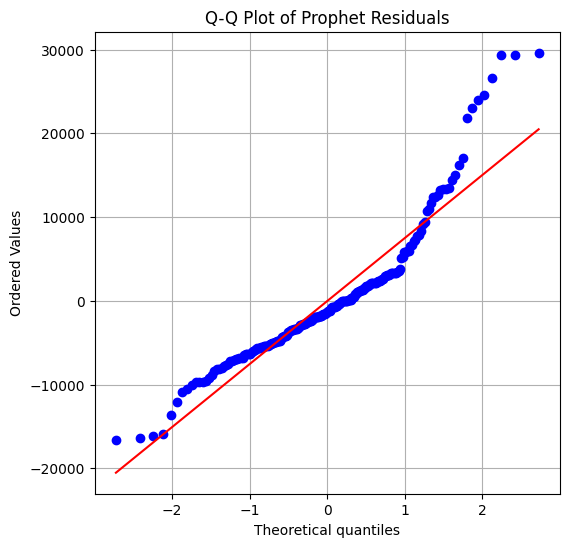

In [91]:
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Prophet Residuals')
plt.grid(True)
plt.show()

Saphiro Wilk

In [92]:
stat, p = shapiro(residuals)
print(f"\n🧪 Shapiro-Wilk: stat = {stat:.4f}, p-value = {p:.4f}")
if p > 0.05:
    print("✅ Residual berdistribusi normal (gagal tolak H0)")
else:
    print("⚠️ Residual tidak berdistribusi normal (tolak H0)")


🧪 Shapiro-Wilk: stat = 0.8928, p-value = 0.0000
⚠️ Residual tidak berdistribusi normal (tolak H0)


Ljung-Box

In [93]:
ljung_result = acorr_ljungbox(residuals, return_df=True)
print("\n📈 Ljung-Box Test:")
print(ljung_result)


📈 Ljung-Box Test:
      lb_stat     lb_pvalue
1   25.815000  3.757568e-07
2   36.904732  9.688113e-09
3   48.402469  1.748320e-10
4   55.030626  3.201324e-11
5   63.886423  1.907220e-12
6   73.007617  9.863403e-14
7   73.831972  2.475379e-13
8   76.993320  1.965583e-13
9   78.323261  3.477134e-13
10  79.544588  6.165648e-13
